### Synthetic Drift Detection ###

In [6]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import matplotlib.pyplot as plt

sys.path.append("../..")

from drift_detection.drift_detector.plotter import plot_drift_samples_pval, errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from drift_detection.drift_detector.utils import scale
from drift_detection.drift_detector.detector import Detector
from drift_detection.drift_detector.reductor import Reductor
from drift_detection.drift_detector.tester import TSTester, DCTester
from drift_detection.drift_detector.experimenter import Experimenter
from drift_detection.drift_detector.synthetic_applicator import SyntheticShiftApplicator, apply_predefined_shift
from torchxrayvision.datasets import NIH_Dataset
from torchxrayvision.datasets import XRayCenterCrop, XRayResizer
import torchvision.transforms as transforms
from torch.utils.data import Subset
import torch

IMAGE_PATH = os.environ['NIHCXR_IMAGE_PATH']
CSV_PATH = os.environ['NIHCXR_CSV_PATH']

# load NIH dataset
dataset = NIH_Dataset(IMAGE_PATH, CSV_PATH, 
                      views=['AP', 'PA'], unique_patients=False, 
                      transform=transforms.Compose([XRayCenterCrop(),
                                                    XRayResizer(224, engine='cv2')]))

# grab random subset of 2000 images from dataset
indices = np.random.randint(len(dataset), size=2000)
dataset = Subset(dataset, indices)

reductor = Reductor(
    dr_method = 'TAE_txrv_CNN',
)

tester = TSTester(
    tester_method='mmd',
)


detector = Detector(
    reductor = reductor,
    tester = tester,
    p_val_threshold = 0.05,
)
detector.fit(dataset)


shiftapplicator = SyntheticShiftApplicator(
    shift_type = "gn_shift",
) 

baseline_experiment = Experimenter(
    'sensitivity_test',
    detector = detector,
)

drift_experiment = Experimenter(
    'sensitivity_test',
    detector = detector,
    shiftapplicator = shiftapplicator,
)

baseline_results = baseline_experiment.run(dataset)
drift_results = drift_experiment.run(dataset)

results = {
    'baseline': baseline_results,
    'experiment': drift_results
}

Setting XRayResizer engine to cv2 could increase performance.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:46<00:00,  1.34s/it]


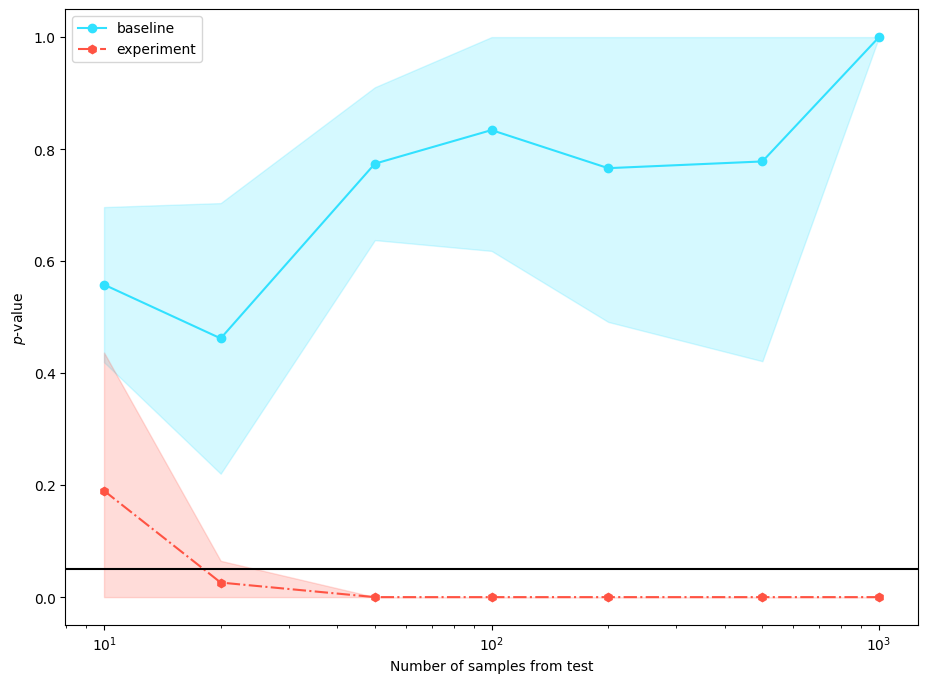

In [4]:
plot_drift_samples_pval(results, 0.05)